In [19]:
import pandas as pd
import numpy as np
from scipy import sparse 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans 
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
#!pip install gensim
import gensim
import warnings
warnings.filterwarnings('ignore')

Load the data

In [2]:
df_raw = pd.read_csv('./data/classify_jobs.csv')
df_raw.head()

,Rating,Years,Salary Estimate Beginning Range,Job Description Length,Scaled Revenue,Scaled_Size,Sector_Accounting & Legal,Sector_Aerospace & Defense,Sector_Agriculture & Forestry,"Sector_Arts, Entertainment & Recreation",...,Sector_Non-Profit,"Sector_Oil, Gas, Energy & Utilities",Sector_Real Estate,"Sector_Restaurants, Bars & Food Services",Sector_Retail,Sector_Telecommunications,Sector_Transportation & Logistics,Sector_Travel & Tourism,Job Description Lem,Label
0,0.550,0.149367,0.132979,0.336867,0.545455,0.333333,0,0,0,0,...,1,0,0,0,0,0,0,0,eager roll sleeve harness data drive policy ch...,Data Analyst
1,0.700,0.321519,0.132979,0.203047,0.818182,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,overview provides analytical technical support...,Data Analyst
2,0.600,0.043038,0.132979,0.234846,NaN,0.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,looking senior love mentorship data visualizat...,Data Analyst
3,0.775,0.045570,0.132979,0.252733,0.454545,0.333333,0,0,0,0,...,0,0,0,0,0,0,0,0,requisition numberrr remote yes collaborate cr...,Data Analyst
4,0.725,0.027848,0.132979,0.175886,0.545455,0.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,fanduel group fanduel group world class team b...,Data Analyst


Creating Training and Test Datasets

In [3]:
# shuffle the rows  and take out the na for job description
df_raw = df_raw[~df_raw['Job Description Lem'].isna()]
df = df_raw.sample(frac=1, random_state= 13).reset_index(drop=True)
# drops the label
df_no_label = np.matrix(df.drop(columns = ['Label']))
label = df['Label']

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(df_no_label, label, test_size=0.1, random_state=42)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)

y_val = y_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
print('Training data size:', X_train_raw.shape[0])
print('Validation data size:', X_val_raw.shape[0])
print('Test data size:', X_test_raw.shape[0])

Training data size: 8676
Validation data size: 2170
Test data size: 1206


Use TfidVectorizer because we want the words that distinguish between the documents.





In [5]:
# min_df = When building the vocabulary ignore terms that have a document frequency 
# strictly lower than the given threshold.
# The parameter represents a proportion of documents, integer absolute counts. 
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.05, max_df=.8) 
train_sentences = np.array(X_train_raw[:,31].T)[0].astype('U')
train_vect = vectorizer.fit_transform(train_sentences)

val_sentences = np.array(X_val_raw[:,31].T)[0].astype('U')
test_sentences = np.array(X_test_raw[:,31].T)[0].astype('U')
# not fitting because the words needs to be from the training dataset
val_vect = vectorizer.transform(val_sentences)
test_vect = vectorizer.transform(test_sentences)

In [6]:
print('Number of features/words from TfidVectorizer:', train_vect.shape[1])

Number of features/words from TfidVectorizer: 866


In [7]:
# top tfid features
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(train_vect.toarray()).flatten()[::-1]

n = 30
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['healthcare', 'professional', 'excellent', 'provider',
       'organization', 'skill', 'leading', 'com', 'solution', 'including',
       'technology', 'looking', 'job', 'location', 'industry', 'client',
       'description', 'software', 'foundation', 'powered', 'engagement',
       'answer', 'website', 'player', 'associated', 'regulatory',
       'extensive', 'interested', 'company', 'demonstrate'], dtype='<U15')

In [8]:
# some features in our dataset
feature_names = vectorizer.get_feature_names() + df.drop(columns = ['Job Description Lem','Label']).columns.tolist()
np.random.seed(4)
np.random.choice(feature_names, 30)

array(['collaborative', 'country', 'leading', 'science', 'help', 'power',
       'location', 'understand', 'increase', 'associated', 'store',
       'Scaled_Size', 'classification', 'pregnancy', 'university', 'file',
       'Sector_Accounting & Legal', 'require', 'approach', 'expected',
       'college', 'passion', 'improvement', 'ability', 'currently',
       'operate', 'comprehensive', 'script', 'issue', 'monitoring'],
      dtype='<U41')

In [9]:
# grabbing the data without words so we can combine the matrices together
train_no_words = X_train_raw[:,:31]
val_no_words = X_val_raw[:,:31]
test_no_words = X_test_raw[:,:31]

In [10]:
# combining the data to make the training, val, and test data, making them dataframes because hard to work with sparse matrix
X_train = pd.DataFrame.sparse.from_spmatrix(sparse.hstack([train_vect, train_no_words.astype(float)]), columns = feature_names).fillna(0)
X_val = pd.DataFrame.sparse.from_spmatrix(sparse.hstack([val_vect, val_no_words.astype(float)]),columns = feature_names).fillna(0)
X_test = pd.DataFrame.sparse.from_spmatrix(sparse.hstack([test_vect, test_no_words.astype(float)]), columns = feature_names).fillna(0)

In [11]:
print('Number of features/words in training data set:', X_train.shape[1])

Number of features/words in training data set: 897


In [12]:
# names of data for model: X_train, X_val, X_test, y_train, y_val, y_test

## Model Building

### Supervised Learning: Decision Tree, Random Forest, and Naive Bayes

We chose to look at these models because they have a feature importance attribute and we care about understanding the differences between data scientists, data engineers, and data analysts. 
We used Decision Trees and Random Forest first because of their interpretability. We were able to see how the model decided on each split and what features it chose.

Decision Tree Classifier

In [13]:
decision_tree = DecisionTreeClassifier(class_weight = 'balanced',random_state=42, max_depth=3)
model_dt = decision_tree.fit(X_train,y_train)

In [14]:
# mean accuracy
decision_tree.score(X_val,y_val)

0.6705069124423964

In [20]:
text_representation = tree.export_text(decision_tree, feature_names = list(X_train.columns))
print(text_representation)

|--- engineer <= 0.02
|   |--- Salary Estimate Beginning Range <= 0.30
|   |   |--- scientist <= 0.01
|   |   |   |--- class: Data Analyst
|   |   |--- scientist >  0.01
|   |   |   |--- class: Data Scientist
|   |--- Salary Estimate Beginning Range >  0.30
|   |   |--- pipeline <= 0.06
|   |   |   |--- class: Data Scientist
|   |   |--- pipeline >  0.06
|   |   |   |--- class: Data Engineer
|--- engineer >  0.02
|   |--- statistic <= 0.03
|   |   |--- machine <= 0.11
|   |   |   |--- class: Data Engineer
|   |   |--- machine >  0.11
|   |   |   |--- class: Data Scientist
|   |--- statistic >  0.03
|   |   |--- Salary Estimate Beginning Range <= 0.43
|   |   |   |--- class: Data Scientist
|   |   |--- Salary Estimate Beginning Range >  0.43
|   |   |   |--- class: Data Scientist



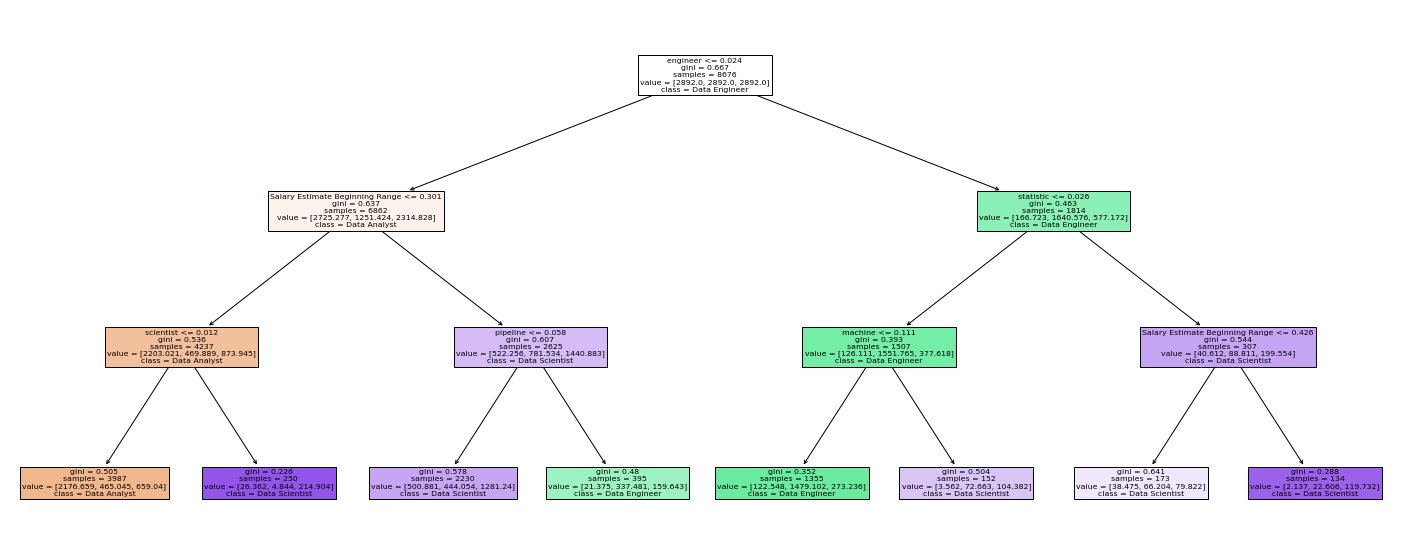

In [21]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(decision_tree, feature_names=X_train.columns,  class_names=['Data Analyst', 'Data Engineer', 'Data Scientist'],filled=True)

In [22]:
# top 20 features of the decision tree
X_train.columns[list(np.argsort(decision_tree.feature_importances_)[-20:][::-1])]

Index(['engineer', 'Salary Estimate Beginning Range', 'scientist', 'pipeline',
       'statistic', 'machine', 'external', 'extensive', 'expression',
       'exposure', 'expertise', 'expert', 'experiment', 'experienced',
       'expected', 'expectation', 'Sector_Travel & Tourism', 'facilitate',
       'existing', 'executive'],
      dtype='object')

Random Forest

In [ ]:
depth = list(range(2,13))
estimators = list(range(100,600,100))
accuracy_depth = []
for i in depth:
    accuracy = []
    for n in estimators:
        random_forest = RandomForestClassifier(max_depth = i, random_state = 15, n_estimators= n)
        random_forest.fit(X_train,y_train)
        accuracy.append(random_forest.score(X_val,y_val))
    accuracy_depth.append(accuracy)


In [ ]:
max_accuracy = []
for i in range(len(depth)):
    max_accuracy.append(max(accuracy_depth[i]))
depth_index = np.argmax(max_accuracy)
depth_max = depth[depth_index]
print("depth corresponding to max accuracy: ", np.argmax(max_accuracy) + 2)
print('estimator corresponding to max estimator:',  estimators[np.argmax(accuracy_depth[depth_index])])
  

In [ ]:
plt.plot(estimators,accuracy_depth[depth_index])
plt.xlabel('Number of Estimators')
plt.ylabel('Random Forest Accuracy')
plt.title('Random Forest accuracy vs Number of Estimators')
plt.show()

In [ ]:
plt.plot(depth,max_accuracy)
plt.xlabel('Max Depth')
plt.ylabel('Random Forest Accuracy')
plt.title('Random Forest Accuracy vs Max Depth')
plt.show()

In [ ]:
random_forest = RandomForestClassifier(max_depth = depth_max, random_state = 18, n_estimators= estimators[np.argmax(accuracy_depth[depth_index])])
random_forest.fit(X_train,y_train)
random_forest.score(X_test,y_test)

In [ ]:
# class: 0 = Data Analyst
# class: 1 = Data Engineer
# class: 2 = Data Scientist
# one decision tree represented
text_representation = tree.export_text(random_forest.estimators_[3], feature_names =list(X_train.columns))
print(text_representation)

In [ ]:
# top 20 features of the random forest
X_train.columns[list(np.argsort(random_forest.feature_importances_)[-20:][::-1])]

Multinomial Naive Bayes

In [ ]:
words_val = X_val[X_val.columns[:train_vect.shape[1]]]
words_train = X_train[X_train.columns[:train_vect.shape[1]]]
words_test = X_test[X_test.columns[:train_vect.shape[1]]]

In [ ]:
# hypertune alpha parameter
alphas = [2,1.7,1.5,1.3,1, 0.7, 0.5,0.3, 0.1, 0.05, 0.01, 0.001,0]
scores = []
for alpha_i in alphas:
    nb = MultinomialNB(alpha= alpha_i)
    nb.fit(words_train, y_train)
    scores.append(nb.score(words_val,y_val))

In [ ]:
# alpha with the largest validation score
alphas[np.argmax(scores)]

In [ ]:
nb = MultinomialNB(alpha= alphas[np.argmax(scores)])
nb.fit(words_train, y_train)

In [ ]:
# mean accuracy for testing data
nb.score(words_test,y_test)

In [ ]:
# class count of Data Analyst, Data Engineer, Data Scientist
nb.class_count_

In [ ]:
# top 20 features for Data Analyst
words_train.columns[list(np.argsort(nb.feature_log_prob_[0])[-20:][::-1])]

In [ ]:
# top 20 features for Data Engineer
words_train.columns[list(np.argsort(nb.feature_log_prob_[1])[-20:][::-1])]

In [ ]:
# top 20 features for Data Scientist
words_train.columns[list(np.argsort(nb.feature_log_prob_[2])[-20:][::-1])]

### Unsupervised Learning: Topic Modeling and K-Means Clustering

These models allowed us to look into the clusters created and to identify the key features used by the model to define each one. We were able to observe whether the clusters created by the model differentiated between the types of jobs and if so, what features belonged to each one. There was also the opportunity to consider whether there are other ways of splitting data-related jobs that may be more insightful than the labels we currently give them.

Topic Modeling

In [ ]:
# train TfidfVectorizer to get matrix of word unigram and bigram frequencies
# exclude stop words, and tokens that appear in < 5% of the documents or > 80% of the documents
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.05, max_df = 0.8, ngram_range=(1,2))
train_tfidf_vect = tfidf_vectorizer.fit_transform(train_sentences)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

# use TF-IDF frequencies to create corpus and dictionary for the LDA model
corpus = gensim.matutils.Sparse2Corpus(train_tfidf_vect, documents_columns=False)
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items()))

In [ ]:
# train several LDA models with varying number of topics
topic_number = range(2, 16)
models = []
for n in topic_number:
    lda_model = gensim.models.LdaModel(corpus, num_topics=n, passes=5, id2word=dictionary, random_state=13)
    models.append(lda_model)

In [ ]:
# compare the coherence of each model to select optimum number of topics
# coherence: measure of the relative distance between words in a topic
coherences = []
for model in models:
    coherence_model = gensim.models.CoherenceModel(model=model, texts=tfidf_vectorizer.inverse_transform(train_tfidf_vect), 
                                     dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherences.append(coherence)

# plot the topic number vs. model coherence
plt.plot(topic_number, coherences)
plt.xlabel("Number of Topics")
plt.ylabel("LDA Model Coherence")
plt.title("Topic Number vs. Coherence");

In [ ]:
# the model with 2 topics has the highest coherence...
model_two_topics = models[0]

# ...but is not very useful in practice
pyLDAvis.enable_notebook()
model_two_vis = pyLDAvis.gensim.prepare(model_two_topics, corpus, dictionary)
model_two_vis

In [ ]:
# looking at the next most coherent model with 5 topics
# these topics seem more intuitive
model_five_topics = models[3]
model_five_vis = pyLDAvis.gensim.prepare(model_five_topics, corpus, dictionary)
model_five_vis

In [ ]:
# looking at the document-topic distribution for each document
doc_topic = [model_five_topics.get_document_topics(doc) for doc in corpus]
doc_topic_df = pd.DataFrame(doc_topic)

# extract topic proportions for each document
# do the topics align with the labels for each document?
for i in range(5):
    doc_topic_df[i], doc_topic_df["topic_" + str(i+1)] = doc_topic_df[i].str

topic_names = {"topic_1":"job applications", "topic_2":"business analysis", 
               "topic_3": "machine learning", "topic_4":"equal opportunity", 
               "topic_5":"data engineering"}

doc_topic_df = doc_topic_df[["topic_1", "topic_2", "topic_3", "topic_4", "topic_5"]].rename(columns=topic_names)
doc_topic_df['label'] = y_train.reset_index(drop=True)
doc_topic_df.head()

In [ ]:
# reweigh the topic proportions to remove the ones that aren't as helpful in distinguishing
# (the job description and equal opportunity topics will likely be in all documents)
important_topics = doc_topic_df.drop(["job applications", "equal opportunity", "label"], axis=1)
reweighted_doc_topic = important_topics.div(important_topics.sum(axis=1), axis=0)
reweighted_doc_topic['label'] = y_train.reset_index(drop=True)
reweighted_doc_topic.groupby("label").mean()

In [ ]:
# plotting topic distribution by class
fig = plt.figure(figsize=(16, 6))

business_analysis = fig.add_subplot(131)
sns.kdeplot(x="business analysis", data=doc_topic_df, hue="label", ax=business_analysis)
plt.title("Dist. of Business Analysis Topic by Class")
plt.ylim(0, 3.75)
plt.xlim(-0.2, 1.2);

machine_learning = fig.add_subplot(132)
sns.kdeplot(x="machine learning", data=doc_topic_df, hue="label", ax=machine_learning)
plt.title("Dist. of Machine Learning Topic by Class")
plt.ylim(0, 3.75)
plt.xlim(-0.2, 1.2);

data_engineering = fig.add_subplot(133)
sns.kdeplot(x="data engineering", data=doc_topic_df, hue="label", ax=data_engineering)
plt.title("Dist. of Data Engineering Topic by Class")
plt.ylim(0, 3.75)
plt.xlim(-0.2, 1.2);

K-Means Clustering

In [ ]:
# finding the ideal number of clusters using the "elbow method"
score = []
for i in range(1,20):
    km = KMeans(n_clusters=i, random_state=18)
    km.fit(words_train)
    score.append(km.score(words_val))
plt.plot(range(1,20), score)
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans Score')
plt.title('Number of Clusters vs KMeans Score')
plt.show()

Unfortunately there doesn't appear to be a clear "elbow", so we decided to try out different numbers of clusters to see if there were any notable patterns.

In [ ]:
for clusters in range(3, 6):
    km = KMeans(n_clusters=clusters, random_state=18)
    km.fit(words_train)

# configure dataframe to show number of each job in each cluster
    km_df = y_val.to_frame()
    km_df['cluster'] = km.predict(words_val)
    temp = pd.DataFrame({'count' : km_df.groupby( ['Label', 'cluster'] ).size()}).reset_index()
    configured = pd.DataFrame(columns=range(clusters))

# show top 10 features per cluster
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    df = pd.DataFrame(columns=range(clusters))

    for i in range(clusters):
        this_column = configured.columns[i]
        out = [0, 0, 0]
        fill = list(temp[temp['cluster'] == i]['count'])
        out[:len(fill)] = fill
        configured[this_column] = out
        this_column = df.columns[i]
        df[this_column] = [feature_names[ind] for ind in order_centroids[i, :20]]

    configured.rename(index={0:'Data Analyst', 1: 'Data Engineer', 2: 'Data Scientist'}, inplace=True)
    df.index.name = 'feature'
    display(df)

# create stacked bar plots
    ttl1 = "{} Clusters: Grouped By Role".format(str(clusters))
    ttl2 = "{} Clusters: Grouped By Cluster".format(str(clusters))
    configured.plot.bar(stacked=True, title = ttl1, rot=0, figsize = (10,5))
    configured.T.plot.bar(stacked=True, title = ttl2, rot=0, figsize = (10,5))

In [ ]:
# taking a closer look at 5 clusters

clusters = 5
km = KMeans(n_clusters=clusters, random_state=18)
km.fit(words_train)

# configure dataframe to show number of each job in each cluster
km_df = y_val.to_frame()
km_df['cluster'] = km.predict(words_val)
temp = pd.DataFrame({'count' : km_df.groupby( ['Label', 'cluster'] ).size()}).reset_index()
configured = pd.DataFrame(columns=range(clusters))

# show top 10 features per cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
df = pd.DataFrame(columns=range(clusters))

for i in range(clusters):
    this_column = configured.columns[i]
    out = [0, 0, 0]
    fill = list(temp[temp['cluster'] == i]['count'])
    out[:len(fill)] = fill
    configured[this_column] = out
    this_column = df.columns[i]
    df[this_column] = [feature_names[ind] for ind in order_centroids[i, :20]]

configured.rename(index={0:'Data Analyst', 1: 'Data Engineer', 2: 'Data Scientist'}, inplace=True)
df.index.name = 'feature'
display(df)

# create stacked bar plots
ttl1 = "{} Clusters: Grouped By Role".format(str(clusters))
ttl2 = "{} Clusters: Grouped By Cluster".format(str(clusters))
configured.plot.bar(stacked=True, title = ttl1, rot=0, figsize = (10,5))
configured.T.plot.bar(stacked=True, title = ttl2, rot=0, figsize = (10,5))

## Conclusion